In [2]:
import os
import re
import tqdm
import string
import pandas as pd
import numpy as np
import util
from sklearn.decomposition import TruncatedSVD
#from data_preprocessing import *
import word_embedding_load as wel
import baseline_classification as bc
import matplotlib.pyplot as plt
from xgboost_classifier import *
import feature_selection_evaluation as fse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
import nltk

/Applications/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
[all_data, train_size, test_size, train_x, train_y, test_x] = util.loadData()

In [4]:
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)

In [5]:
bag_of_words = count_vectorizer.fit_transform(all_data['Text'])

In [6]:
X_bow_train = bag_of_words[:train_size]
X_bow_test = bag_of_words[train_size:]

print(X_bow_train.shape)
print(X_bow_test.shape)

(3689, 310723)
(986, 310723)


In [7]:
svd = TruncatedSVD(n_components=200, n_iter=25, random_state=12)
X_bow_train_k = svd.fit_transform(X_bow_train)
svd = TruncatedSVD(n_components=200, n_iter=25, random_state=25)
X_bow_test_k = svd.fit_transform(X_bow_test)

In [8]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_one_hot_gene = wel.getGeneVec(all_data, svd)
truncated_one_hot_variation = wel.getVariationVec(all_data, svd)

In [9]:
train_set = np.hstack((truncated_one_hot_gene[:train_size], truncated_one_hot_variation[:train_size], X_bow_train_k))
test_set = np.hstack((truncated_one_hot_gene[train_size:], truncated_one_hot_variation[train_size:], X_bow_test_k))

encoded_y = pd.get_dummies(train_y)
encoded_y = np.array(encoded_y)
y = np.array(bc.getLabels(encoded_y))
X_bow = np.array(train_set)

In [10]:
print(X_bow.shape)
print(y.shape)

(3689, 250)
(3689,)


[0]	train-mlogloss:2.12226	valid-mlogloss:2.13784
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[25]	train-mlogloss:1.14855	valid-mlogloss:1.41701
[50]	train-mlogloss:0.734761	valid-mlogloss:1.16043
[75]	train-mlogloss:0.483175	valid-mlogloss:1.04019
[100]	train-mlogloss:0.336755	valid-mlogloss:0.981469
[125]	train-mlogloss:0.240524	valid-mlogloss:0.955722
[150]	train-mlogloss:0.175764	valid-mlogloss:0.947425
[175]	train-mlogloss:0.128857	valid-mlogloss:0.944929
[200]	train-mlogloss:0.096717	valid-mlogloss:0.947579
[225]	train-mlogloss:0.074241	valid-mlogloss:0.950755
[250]	train-mlogloss:0.058275	valid-mlogloss:0.959733
[275]	train-mlogloss:0.046595	valid-mlogloss:0.967679
Stopping. Best iteration:
[179]	train-mlogloss:0.1231	valid-mlogloss:0.944739

final validation loss:
0.944738555676
final validation accuracy:
0.681203007519
[0]	train-mlogloss:2.12146	valid-mlogloss:2.13806


[250]	train-mlogloss:0.059215	valid-mlogloss:0.925355
Stopping. Best iteration:
[169]	train-mlogloss:0.145909	valid-mlogloss:0.909569

final validation loss:
0.909568851223
final validation accuracy:
0.687218045113
[0]	train-mlogloss:2.12212	valid-mlogloss:2.13911
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[25]	train-mlogloss:1.14646	valid-mlogloss:1.47121
[50]	train-mlogloss:0.722028	valid-mlogloss:1.22927
[75]	train-mlogloss:0.480894	valid-mlogloss:1.11043
[100]	train-mlogloss:0.330979	valid-mlogloss:1.05554
[125]	train-mlogloss:0.236147	valid-mlogloss:1.02956
[150]	train-mlogloss:0.171102	valid-mlogloss:1.02122
[175]	train-mlogloss:0.126201	valid-mlogloss:1.02426
[200]	train-mlogloss:0.094758	valid-mlogloss:1.03187
[225]	train-mlogloss:0.072263	valid-mlogloss:1.04043
[250]	train-mlogloss:0.056442	valid-mlogloss:1.05136
Stopping. Best iteration:
[153]	train-mlogloss:0.165514

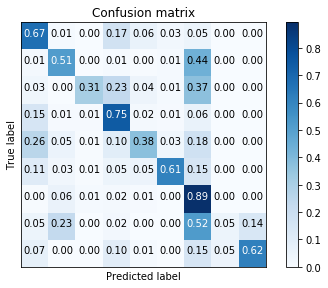

In [11]:
y_predict = xgbclassifier(train_set, y, test_set, 10, 8, 1000)

In [15]:
from testaccuracy import *
savesubmisstion(y_predict, test_x, filename = "bag_of_words.csv")

Accuracy: 0.5687 ± 0.0204
NMI: 0.3146 ± 0.0215
Log_loss: 7.5583 ± 0.4221
Normalized confusion matrix
[[ 0.58761329  0.04833837  0.01359517  0.14954683  0.0755287   0.03323263
   0.09063444  0.00151057  0.        ]
 [ 0.11445783  0.46586345  0.00200803  0.04618474  0.01606426  0.02811245
   0.32730924  0.          0.        ]
 [ 0.13541667  0.02083333  0.33333333  0.19791667  0.04166667  0.
   0.27083333  0.          0.        ]
 [ 0.23035952  0.03728362  0.01731025  0.64713715  0.01198402  0.00798935
   0.04793609  0.          0.        ]
 [ 0.26966292  0.07490637  0.02996255  0.11235955  0.39700375  0.01498127
   0.1011236   0.          0.        ]
 [ 0.15824916  0.06397306  0.01683502  0.05050505  0.03703704  0.5993266
   0.07407407  0.          0.        ]
 [ 0.09392789  0.17172676  0.0256167   0.05882353  0.0170778   0.00379507
   0.62523719  0.00094877  0.0028463 ]
 [ 0.23809524  0.38095238  0.          0.          0.          0.
   0.33333333  0.          0.04761905]
 [ 0.1627907

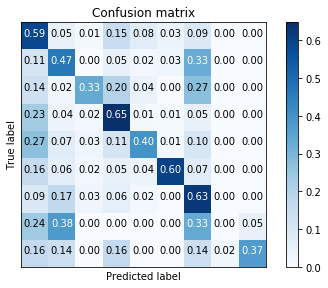

array([[ 0.58761329,  0.04833837,  0.01359517,  0.14954683,  0.0755287 ,
         0.03323263,  0.09063444,  0.00151057,  0.        ],
       [ 0.11445783,  0.46586345,  0.00200803,  0.04618474,  0.01606426,
         0.02811245,  0.32730924,  0.        ,  0.        ],
       [ 0.13541667,  0.02083333,  0.33333333,  0.19791667,  0.04166667,
         0.        ,  0.27083333,  0.        ,  0.        ],
       [ 0.23035952,  0.03728362,  0.01731025,  0.64713715,  0.01198402,
         0.00798935,  0.04793609,  0.        ,  0.        ],
       [ 0.26966292,  0.07490637,  0.02996255,  0.11235955,  0.39700375,
         0.01498127,  0.1011236 ,  0.        ,  0.        ],
       [ 0.15824916,  0.06397306,  0.01683502,  0.05050505,  0.03703704,
         0.5993266 ,  0.07407407,  0.        ,  0.        ],
       [ 0.09392789,  0.17172676,  0.0256167 ,  0.05882353,  0.0170778 ,
         0.00379507,  0.62523719,  0.00094877,  0.0028463 ],
       [ 0.23809524,  0.38095238,  0.        ,  0.        ,  0

In [78]:
bc.baseline(X_bow, y)

In [79]:
import pickle
# save
with open('../data/feature/X_bow_test.pkl', 'wb') as f:
    pickle.dump(X_bow_test, f)
    f.close()
with open('../data/feature/X_bow_train.pkl', 'wb') as f:
    pickle.dump(X_bow, f)
    f.close()
with open('../data/feature/label_bow.pkl', 'wb') as f:
    pickle.dump(y, f)
    f.close()

In [80]:
#load
with open('../data/feature/X_bow_test.pkl', 'rb') as f:
    X_bow_test = pickle.load(f)
    f.close()
with open('../data/feature/X_bow_train.pkl', 'rb') as f:
    X_bow = pickle.load(f)
    f.close()
with open('../data/feature/label_bow.pkl', 'rb') as f:
    y = pickle.load(f)
    f.close()
